# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

Будем использовать датасет "Red Wine Quality", содержащий данные о красном португальском "Vinho Verde".

In [1]:
import numpy as np
import pandas as pd 

In [2]:
#Загрузим данные и предварительно изучим их
data = pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
data['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [5]:
#Будем делать бинарную классификацию по целевому признаку(quality)
#Разделим вино на "хорошее" и "плохое", задав лимиты для quality
bins = (2, 6, 8)
group_names = ['bad', 'good']
data['quality'] = pd.cut(data['quality'], bins = bins, labels = group_names)

In [6]:
#"Плохому" вину присваиваем зачение 0, "хорошему" - 1
from sklearn.preprocessing import LabelEncoder
label_quality = LabelEncoder()
data['quality'] = label_quality.fit_transform(data['quality'])
data['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [7]:
#Разделим датасет на целевой признак (y) и отсальные (X)
X = data.drop('quality', axis = 1)
y = data['quality']

In [8]:
#Разделим выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
#Применим стандартное масштабирование
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [10]:
#Сделаем классификацию, используя метод k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=3)
KNN

KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(X_test)

In [11]:
#Оценим качество модели с помощью метрик
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, KNN_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       273
           1       0.56      0.40      0.47        47

    accuracy                           0.87       320
   macro avg       0.73      0.67      0.70       320
weighted avg       0.85      0.87      0.86       320



In [12]:
confusion_matrix(y_test, KNN_pred)

array([[258,  15],
       [ 28,  19]], dtype=int64)

In [13]:
# Построим модель с использованием кросс-валидации
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
cross_val = cross_val_score(KNN, X = X_train, y = y_train, cv = kf)
cross_val

array([0.85546875, 0.90234375, 0.828125  , 0.8671875 , 0.88235294])

In [14]:
#Произведем оптимизацию гиперпараметра

n_range = np.array(range(1,45))
param = [{'n_neighbors': n_range}]

grid_knn = GridSearchCV(KNN, param_grid=param, scoring='accuracy', cv=10)
grid_knn.fit(X_train, y_train)
grid_knn.best_params_

{'n_neighbors': 2}

In [15]:
# Построим модель еще раз с наиболее оптимальным параметром
KNN = KNeighborsClassifier(n_neighbors=2)
cross_val = cross_val_score(KNN, X = X_train, y = y_train, cv = kf)
cross_val

array([0.875     , 0.8828125 , 0.828125  , 0.88671875, 0.90196078])

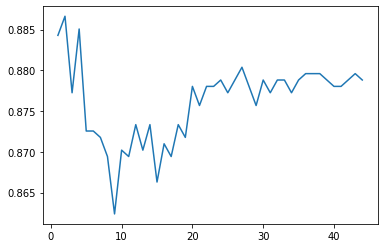

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_range, grid_knn.cv_results_['mean_test_score'])